In [3]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import time
class Queue:
    """
    Implement the queue abstract data type for breathfirst use.
    Support: enqueue, dequeue, ieEmpty and front.
    """
    class _Node:
        """
        _Node is a private class used to represent nodes in the linked list
        that is implenting the type.
        """
        __slots__ = 'data', 'next'

        def __init__(self, data=None, next=None):
            """
            A node constructor for implementing the queue
            """
            self.data = data
            self.next = next
    def __init__(self):
        """
        Queue constructor
        """
        self._head = None
        self._tail = None
        self._size = 0
    def enqueue(self, item):
        """
        enqueue: adds the item at the tail of the list.
        """
        if self._head is None:
            self._head = self._tail = self._Node(item)
            self._size +=1
        else:
            self._tail.next = self._Node(item)
            self._tail = self._tail.next
            self._size +=1
    def dequeue(self):
        """
        dequeue: remove and return the next item.
        """
        if self._head is None:
            raise ValueError
        result = self._head.data
        self._head = self._head.next
        self._size -=1
        if self._head is None:
            self.tail = None
        return result

    def is_empty(self):
        """
        isEmpty: a queue is empty iff its _head is None.
        """
        return self._head is None

    def front(self):
        """
        Returns a reference to the data item
        in the first node.
        """
        if self is None:
            raise ValueError
        return self._head.data
    def __len__(self):
        """
        length method, return the length of the queue
        """
        return self._size

class Tree:

    # ------------------------ nested Position class --------------------------
    class Position:
        """
        Abstraction representing the location of a single element within a tree
        """

        def __init__(self, container, node):
            """Constructor should not be invoked by user."""
            self._container = container
            self._node = node

        def element(self):
            """Return the element stored at this Position."""
            return self._node._element
        def score(self):
            """
            Return the score of the board representing by this position
            """
            return self._node._score

        def __eq__(self, other):
            """
            Return True iff other is a Position representing the same location.
            """
            return type(other) is type(self) and other._node is self._node

    # -------------------------- nested _Node class --------------------------
    class _Node:
        """
        Lightweight, nonpublic class for storing a node.
        _element stores the board, _parent stores parent's position, _score stores board's score, _children is a list storing
        all the positions node's children's
        """
        __slots__ = '_element', '_parent', '_children', '_score'
        def __init__(self, element, parent=None, children = None,score=None):
            self._element = element
            self._parent = parent
            self._score = score
            if children == None:
                # default value of children
                self._children = []
            else:
                self._children = children
    # --------------------------tree constructor ----------------------
    def __init__(self):
        """Create an initially empty tree."""
        self._root = None
        self._size = 0

    # -------------------------- public accessors --------------------------
    def __len__(self):
        """Return the total number of elements in the tree."""
        return self._size

    def root(self):
        """Return the root position of the tree (or None if tree is empty)."""
        return self._make_position(self._root)

    def parent(self, p):
        """Return the position of p's parent (or None if p is root)."""
        node = self._validate(p)
        return self._make_position(node._parent)

    def num_children(self, p):
        """Return the number of children of position p."""
        node = self._validate(p)
        return len(node._children)

    def sibling(self, p):
        """
        Return a Position representing p s sibling (or None if no sibling).
        """
        parent = self.parent(p)
        result = []
        if parent is None:  # p must be the root
            return None    # root has no sibling
        else:
            for child in self.children(self,parent):
                if child != p:
                    result.append(child)
                else:
                    continue# possibly None
        return result
    
    def children(self, p):
        """
        A generator yielding every single child of position P 's position
        """
        node = self._validate(p)
        if len(node._children) != 0:
            for child in node._children:
                yield self._make_position(child)

    def is_root(self, p):
        """Return True if position P represents the root of the tree."""
        return self.root() == p

    def is_leaf(self, p):
        """Return True if position P does not have any children."""
        return self.num_children(p) == 0

    def is_empty(self):
        """Return True if the tree is empty."""
        return len(self) == 0

    def depth(self, p):
        """Return the number of levels separating Position p from the root."""
        return 0 if self.is_root(p) else 1 + self.depth(self.parent(p))


    # ------------------------------- utility methods -------------------------------
    def _validate(self, p):
        """Return associated node, if position is valid."""
        if not isinstance(p, self.Position):
            raise TypeError('p must be proper Position type')
        if p._container is not self:
            raise ValueError('p does not belong to this container')
        if p._node._parent is p._node:      # convention for deprecated nodes
            raise ValueError('p is no longer valid')
        return p._node

    def _make_position(self, node):
        """Return Position instance for given node (or None if no node)."""
        return self.Position(self, node) if node is not None else None

    # -------------------------- nonpublic mutators --------------------------
    def _add_root(self, e):
        """
        Place element e at the root of an empty tree and return new Position.
        Raise ValueError if tree nonempty.
        """
        if self._root is not None:
            raise ValueError('Root exists')
        self._size = 1
        self._root = self._Node(e)
        return self._make_position(self._root)

    def _add_child(self, p, e):
        """
        Adding a new child for position P, storing element e
        Retrn the position of the latest added child
        """
        node = self._validate(p)
        self._size += 1
        node._children.append(self._Node(e, node))                  # node is its parent
        return self._make_position(node._children[-1])

    def _add_score(self,p,score):
        """
        Adding a score to position P
        Return the score added
        """
        node = self._validate(p)
        node._score = score
        return node._score

    def _replace(self, p, e):
        """
        Replace the element at position p with e, and return the current element.
        """
        node = self._validate(p)
        node._element = e
        return e


    def __iter__(self):
        """Generate an iteration of the tree's elements."""
        for p in self.positions():            # use same order as positions()
            yield p                          # but yield each element

    def positions(self):
        """Generate an iterable of the tree's positions."""
        #return self.preorder()     # return entire preorder iteration
        return self.breadthfirst()
    def breadthfirst(self):
        """Generate a breadth-first iteration of the positions of the tree."""
        if not self.is_empty():
            fringe = Queue()                  # known positions not yet yielded
            fringe.enqueue(self.root())       # starting with the root
            while not fringe.is_empty():
                p = fringe.dequeue()          # remove from front of the queue
                yield p                       # report this position
                for c in self.children(p):
                    fringe.enqueue(c)         # add children to back of queue

In [2]:
def game_constructor(unroll_depth):
    counter = 0
    #print("constructing..\n")
    board = Tree()
    board._add_root("X")
    cur_pos = board.root()
    gen_board(board,cur_pos,counter,unroll_depth)
    #print("constructed!\n")
    
    return board
    
    
def gen_board(board,pos,counter,unroll_depth,score_init = True):
    cur_val = pos.element()
    if counter < unroll_depth:
        new_pos_1 = board._add_child(pos,cur_val+"0")
        new_pos_2 = board._add_child(pos,cur_val+"1")
        gen_board(board,new_pos_1,counter+1,unroll_depth)
        gen_board(board,new_pos_2,counter+1,unroll_depth)
    else:
        if score_init:
            #score = np.random.normal()
            score = np.random.uniform(-1.0,1.0)
            #score = np.random.poisson()
            #score = np.random.exponential()
            board._add_score(pos,score)
            
def scoring_master(board):
    if ORDER == "minmax":
        scoring_min_max_master(board)
    elif ORDER == "maxmin":
        scoring_max_min_master(board)
    return
def scoring_min_max_master(board):
    choice = []
    for child in board.children(board.root()):
        score = scoring_min_max_first(board,child)
        choice.append(score)
    minvalue = min(choice)
    board._add_score(board.root(),minvalue)
    #print("scoring Done!")
    return
def scoring_max_min_master(board):
    choice = []
    for child in board.children(board.root()):
        score = scoring_max_min_first(board,child)
        choice.append(score)
    maxvalue = max(choice)
    board._add_score(board.root(),maxvalue)
    #print("scoring Done!")
    return
def scoring_min_max_first(board,position):
    if board.is_leaf(position):
        return position.score()
    else:
        choice = []
        for child in board.children(position):
            score = scoring_min_max_second(board,child)
            choice.append(score)
        minvalue = min(choice)
        board._add_score(position,minvalue)
        return position.score()
def scoring_min_max_second(board,position):
    if board.is_leaf(position):
        return position.score()
    else:
        choice = []
        for child in board.children(position):
            score = scoring_min_max_first(board,child)
            choice.append(score)
        maxvalue = max(choice)
        board._add_score(position,maxvalue)
        return position.score()
def scoring_max_min_first(board,position):
    if board.is_leaf(position):
        return position.score()
    else:
        choice = []
        for child in board.children(position):
            score = scoring_max_min_second(board,child)
            choice.append(score)
        maxvalue = max(choice)
        board._add_score(position,maxvalue)
        return position.score()
def scoring_max_min_second(board,position):
    if board.is_leaf(position):
        return position.score()
    else:
        choice = []
        for child in board.children(position):
            score = scoring_max_min_first(board,child)
            choice.append(score)
        minvalue = min(choice)
        board._add_score(position,minvalue)
        return position.score()

    

    

In [6]:
#test part: change N to see the tree
N=5
UNROLL_DEPTH = N
ORDER = "maxmin"
EPOCH = 22
# DIS_TYPE = "unit_gaussian"
# DIS_TYPE = "uniform"
# if DIS_TYPE == "unit_gaussian":
#     dstr = np.random.normal
# elif DIS_TYPE == "uniform":
#     print("activated")
#     dstr = np.random.uniform
    
# OBSOLETE: I don't know why but it doesn't work... please tweak distribution within game_constructor function




board = game_constructor(N)
scoring_master(board)
sanity_leaf_score = []
print (board.root().score(),"\n")
for position in board:
    if board.is_leaf(position):
        sanity_leaf_score.append(position.score())
    print((position.element(),position.score()),"\n")


constructing..

constructed!

scoring Done!
0.33216211582825306 

('X', 0.33216211582825306) 

('X0', 0.33216211582825306) 

('X1', -0.2386531908526428) 

('X00', -0.5833559703317963) 

('X01', 0.33216211582825306) 

('X10', -0.2386531908526428) 

('X11', -0.4818130079646543) 

('X000', 0.32949733140500137) 

('X001', -0.5833559703317963) 

('X010', 0.9178477122665993) 

('X011', 0.33216211582825306) 

('X100', -0.18287631066071341) 

('X101', -0.2386531908526428) 

('X110', -0.4818130079646543) 

('X111', -0.060426103550772936) 

('X0000', 0.32949733140500137) 

('X0001', 0.02093053320116578) 

('X0010', -0.7485317944226881) 

('X0011', -0.5833559703317963) 

('X0100', -0.4147962196114203) 

('X0101', 0.9178477122665993) 

('X0110', 0.33216211582825306) 

('X0111', -0.4723212719729344) 

('X1000', -0.18287631066071341) 

('X1001', -0.7434182625994319) 

('X1010', -0.3727270520102959) 

('X1011', -0.2386531908526428) 

('X1100', -0.4818130079646543) 

('X1101', -0.9662035045311121) 

(

In [3]:
#generate result run part
start_time = time.time()
result = []
for i in range (0,50):
    print (i)
    temp = []
    for N in range(1,21):
        UNROLL_DEPTH = N
        ORDER = "maxmin"
        board = game_constructor(N)
        scoring_master(board)
        sanity_leaf_score = []
        temp.append(board.root().score())
        for position in board:
            if board.is_leaf(position):
                sanity_leaf_score.append(position.score())
    result.append(temp)

print("--- %s seconds ---" % (time.time() - start_time))
            
#for i in range(0,len(result)):
    #print (result[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
--- 12560.435427904129 seconds ---


In [4]:
print (result)

[[0.7582633950543716, 0.5703783865597811, -0.472487355260367, 0.3443724479863375, -0.16889070806484896, 0.03102378339692846, -0.30256778781586435, 0.36729972384995313, 0.03320831524480794, 0.2867103893034242, -0.16863804659303372, 0.3505991417244838, -0.17116057909053195, 0.2619444086627012, -0.20215141617663113, 0.23632924578372694, -0.2069380508461658, 0.25640985626241997, -0.24289441270359724, 0.24402270809932758], [0.3536382967940632, 0.8430775773530754, 0.49463076880104184, 0.2958923530351192, 0.09765774439106312, 0.22732105996742846, -0.1407742707662687, 0.29269361565308594, -0.20172848889957962, 0.3862812844046273, -0.0476355992440225, 0.23617759704255037, -0.18920276325183294, 0.26532393260166187, -0.2000005133474887, 0.3213345171810835, -0.18023136454140043, 0.27201106786702733, -0.23904344086090634, 0.24019134461841007], [0.5977491751759634, 0.9874350451312981, 0.36400942471998854, 0.5118721490648237, 0.009983960996677643, 0.7345456344618062, -0.08621422605234574, 0.581038383

In [15]:
result_matrix = np.matrix(result)
result_matrix = result_matrix.transpose()
result_matrix

matrix([[ 0.69706918,  0.96969786,  0.24153308,  0.60069203, -0.21835702,
          0.61632604, -0.38816362,  0.22635581,  0.90776738, -0.02311192,
          0.23456534,  0.66270109,  0.44214709,  0.29693452,  0.18148653,
          0.08396778,  0.98518662,  0.90003737,  0.58705688, -0.54664215],
        [-0.05416142,  0.84476214,  0.59500398, -0.08090726,  0.19465867,
          0.98332005,  0.12247987,  0.84191703,  0.25315148,  0.36618184,
          0.19001828,  0.91131323,  0.20647196, -0.15526844,  0.65564506,
          0.49369221,  0.53235682,  0.77188351,  0.77029308,  0.98486692],
        [ 0.37070615,  0.08718276, -0.04231222, -0.02361194,  0.22319138,
         -0.30178827,  0.77974513,  0.78755153, -0.45776049,  0.05780164,
         -0.13617305,  0.12431463,  0.02139281,  0.50900125, -0.27390753,
          0.85154026,  0.79175191,  0.11315021,  0.12002872,  0.23222739],
        [-0.21782123,  0.20682837,  0.36179668,  0.58134935,  0.50549282,
          0.93382219,  0.24723922, 

In [6]:
import csv
import re
import pandas as pd
df = pd.DataFrame(result_matrix)
df.to_csv("game_result_20_u.csv")

NameError: name 'result_matrix' is not defined

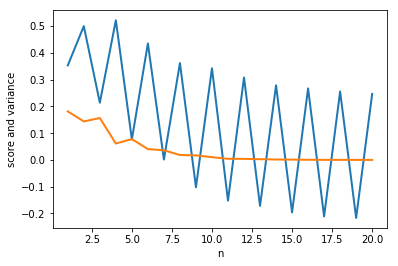

In [8]:
import csv
import pandas as pd
result = pd.read_csv('game_result_20_u.csv')
result2 = pd.read_csv('game_result2_20_u.csv')
del result['Unnamed: 0']
del result2['Unnamed: 0']
result = np.matrix(result.values)
result2 = np.matrix(result2.values)
t_result = np.concatenate((result, result2), axis=1)
df_result = pd.DataFrame(t_result)
df_result.to_csv("game_result_70.csv")
t_result.shape
x = np.arange(1, 21)
y = np.mean(t_result, axis=1)
v = np.var(t_result, axis=1)
plt.xlabel('n')
plt.ylabel('score and variance')
plt.plot(x, y, linewidth=2.0)
plt.plot(x, v, linewidth=2.0)
plt.show()

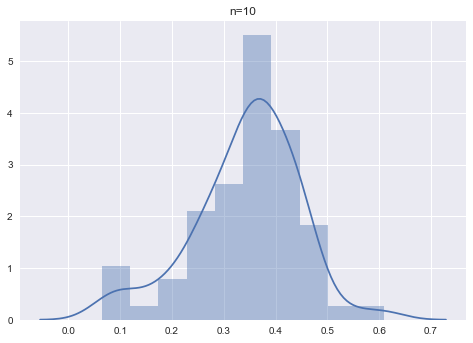

In [131]:
import seaborn as sns
sns.distplot(t_result[9])
plt.title('n=10')
plt.show()

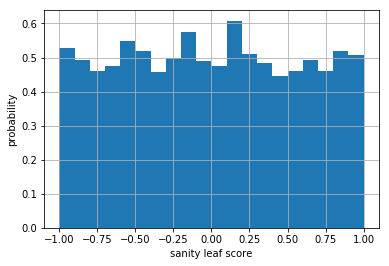

In [119]:
#sanity check: check that the leaf score is indeed gaussian distributed!
n,bins,patches = plt.hist(sanity_leaf_score,20,normed = 1)
plt.xlabel('sanity leaf score')
plt.ylabel('probability')
plt.grid(True)
plt.show()

In [15]:
def playground(n_candidate = [2,4,6,8,10]):
    mean_list = []
    var_list = []
    mega_var = []
    for n in n_candidate:
        temp = []
        for i in range(EPOCH):
            board = game_constructor(n)
            scoring_master(board)
            temp.append(board.root().score())
        mean = np.mean(temp)
        var = stat.pvariance(temp)
        mean_list.append(mean)
        var_list.append(var)
        mega_var.append(temp)
    mega_var = np.array(mega_var)
    mean_list = np.array(mean_list)
    var_list = np.array(var_list)
    plt.errorbar(n_candidate,mean_list,yerr = mean_list*var_list)
    plt.plot(n_candidate,mega_var,'ro')
    #comment out the line above to show error bar; not sure how to use though
    plt.show()
    

constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructing..

scoring Done!
constructi

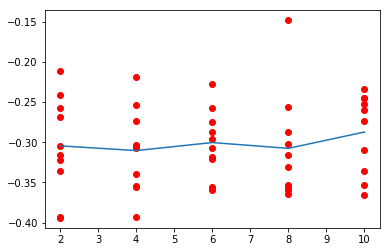

In [130]:
playground()